# 11. Supplementary Figure 5

This notebook is used to create the panels of Supplementary Figure 5.

Before starting, use 1.Preprocessing notebook to generate:
- SC3_normalized.h5ad - Normalized single-cell data

SC3_DA_condition_markers.csv - Selected SC markers
    - For a full list execute Panel C of Figure 7

In [1]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import scanpy as sc
from anndata import read_h5ad, concat
import outer_spacem as osm
import numpy as np
from scipy import stats
from joypy import joyplot
import re
import networkx as nx
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

import sys
sys.path.insert(0, '../functions/')
import pl
import utils

### Set plot style

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats=['retina']
sns.set(rc={'figure.figsize':(5, 5),
            'legend.frameon':False},
        style='ticks',
        context='talk')

# Render figures with higher resolution.
plt.rcParams['figure.dpi']=200
# Save with transparent regions white background.
plt.rcParams['savefig.facecolor']='white'

### Set color palette

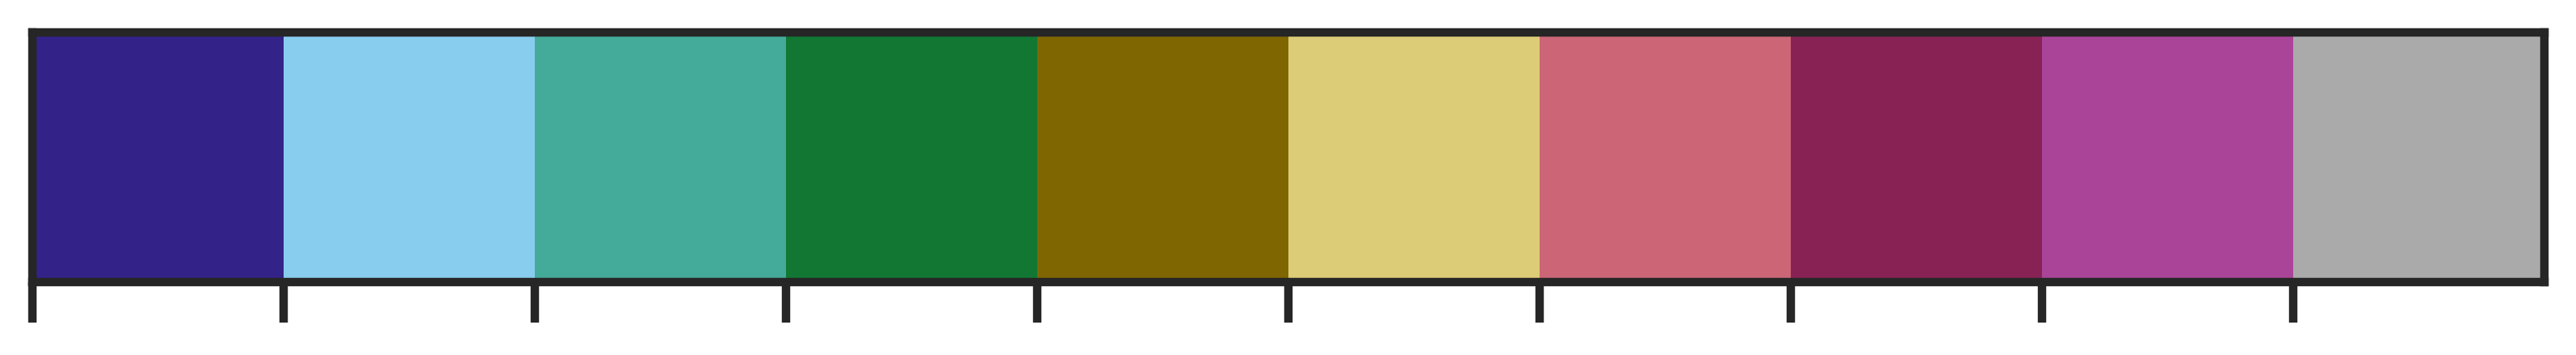

In [3]:
#color palette
palette = [(51,34,136),(136,204,238),(68,170,153),(17,119,51),(128,102,0),(221,204,119),(204,102,119),(136,34,85),(170,68,153),(170,170,170)]
palette = [(e[0]/255.0, e[1]/255.0, e[2]/255.0) for e in palette]
cmap = ListedColormap(palette)
sns.color_palette(palette=None,as_cmap=True)
sns.palplot(palette)

## Panel A, Panel B and Panel C

### Set paths

In [4]:
#input
data_dir = Path(r'../data')
anndata_path = data_dir / 'SC3_normalized.h5ad'
markers_path = data_dir / 'SC3_DA_condition_markers.csv'

#output
plots_path =  Path(r'../') / 'figures' / 'supplementary_figure_5'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [5]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)
adata.raw = adata

#load markers file
DA_markers = pd.read_csv(markers_path)

### Panel A - UMAP

In [6]:
sc.pp.pca(adata)
sc.external.pp.bbknn(adata, batch_key='well')
sc.tl.umap(adata, random_state=12345) 
adata.obs[['UMAP1', 'UMAP2']] = adata.obsm['X_umap']

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


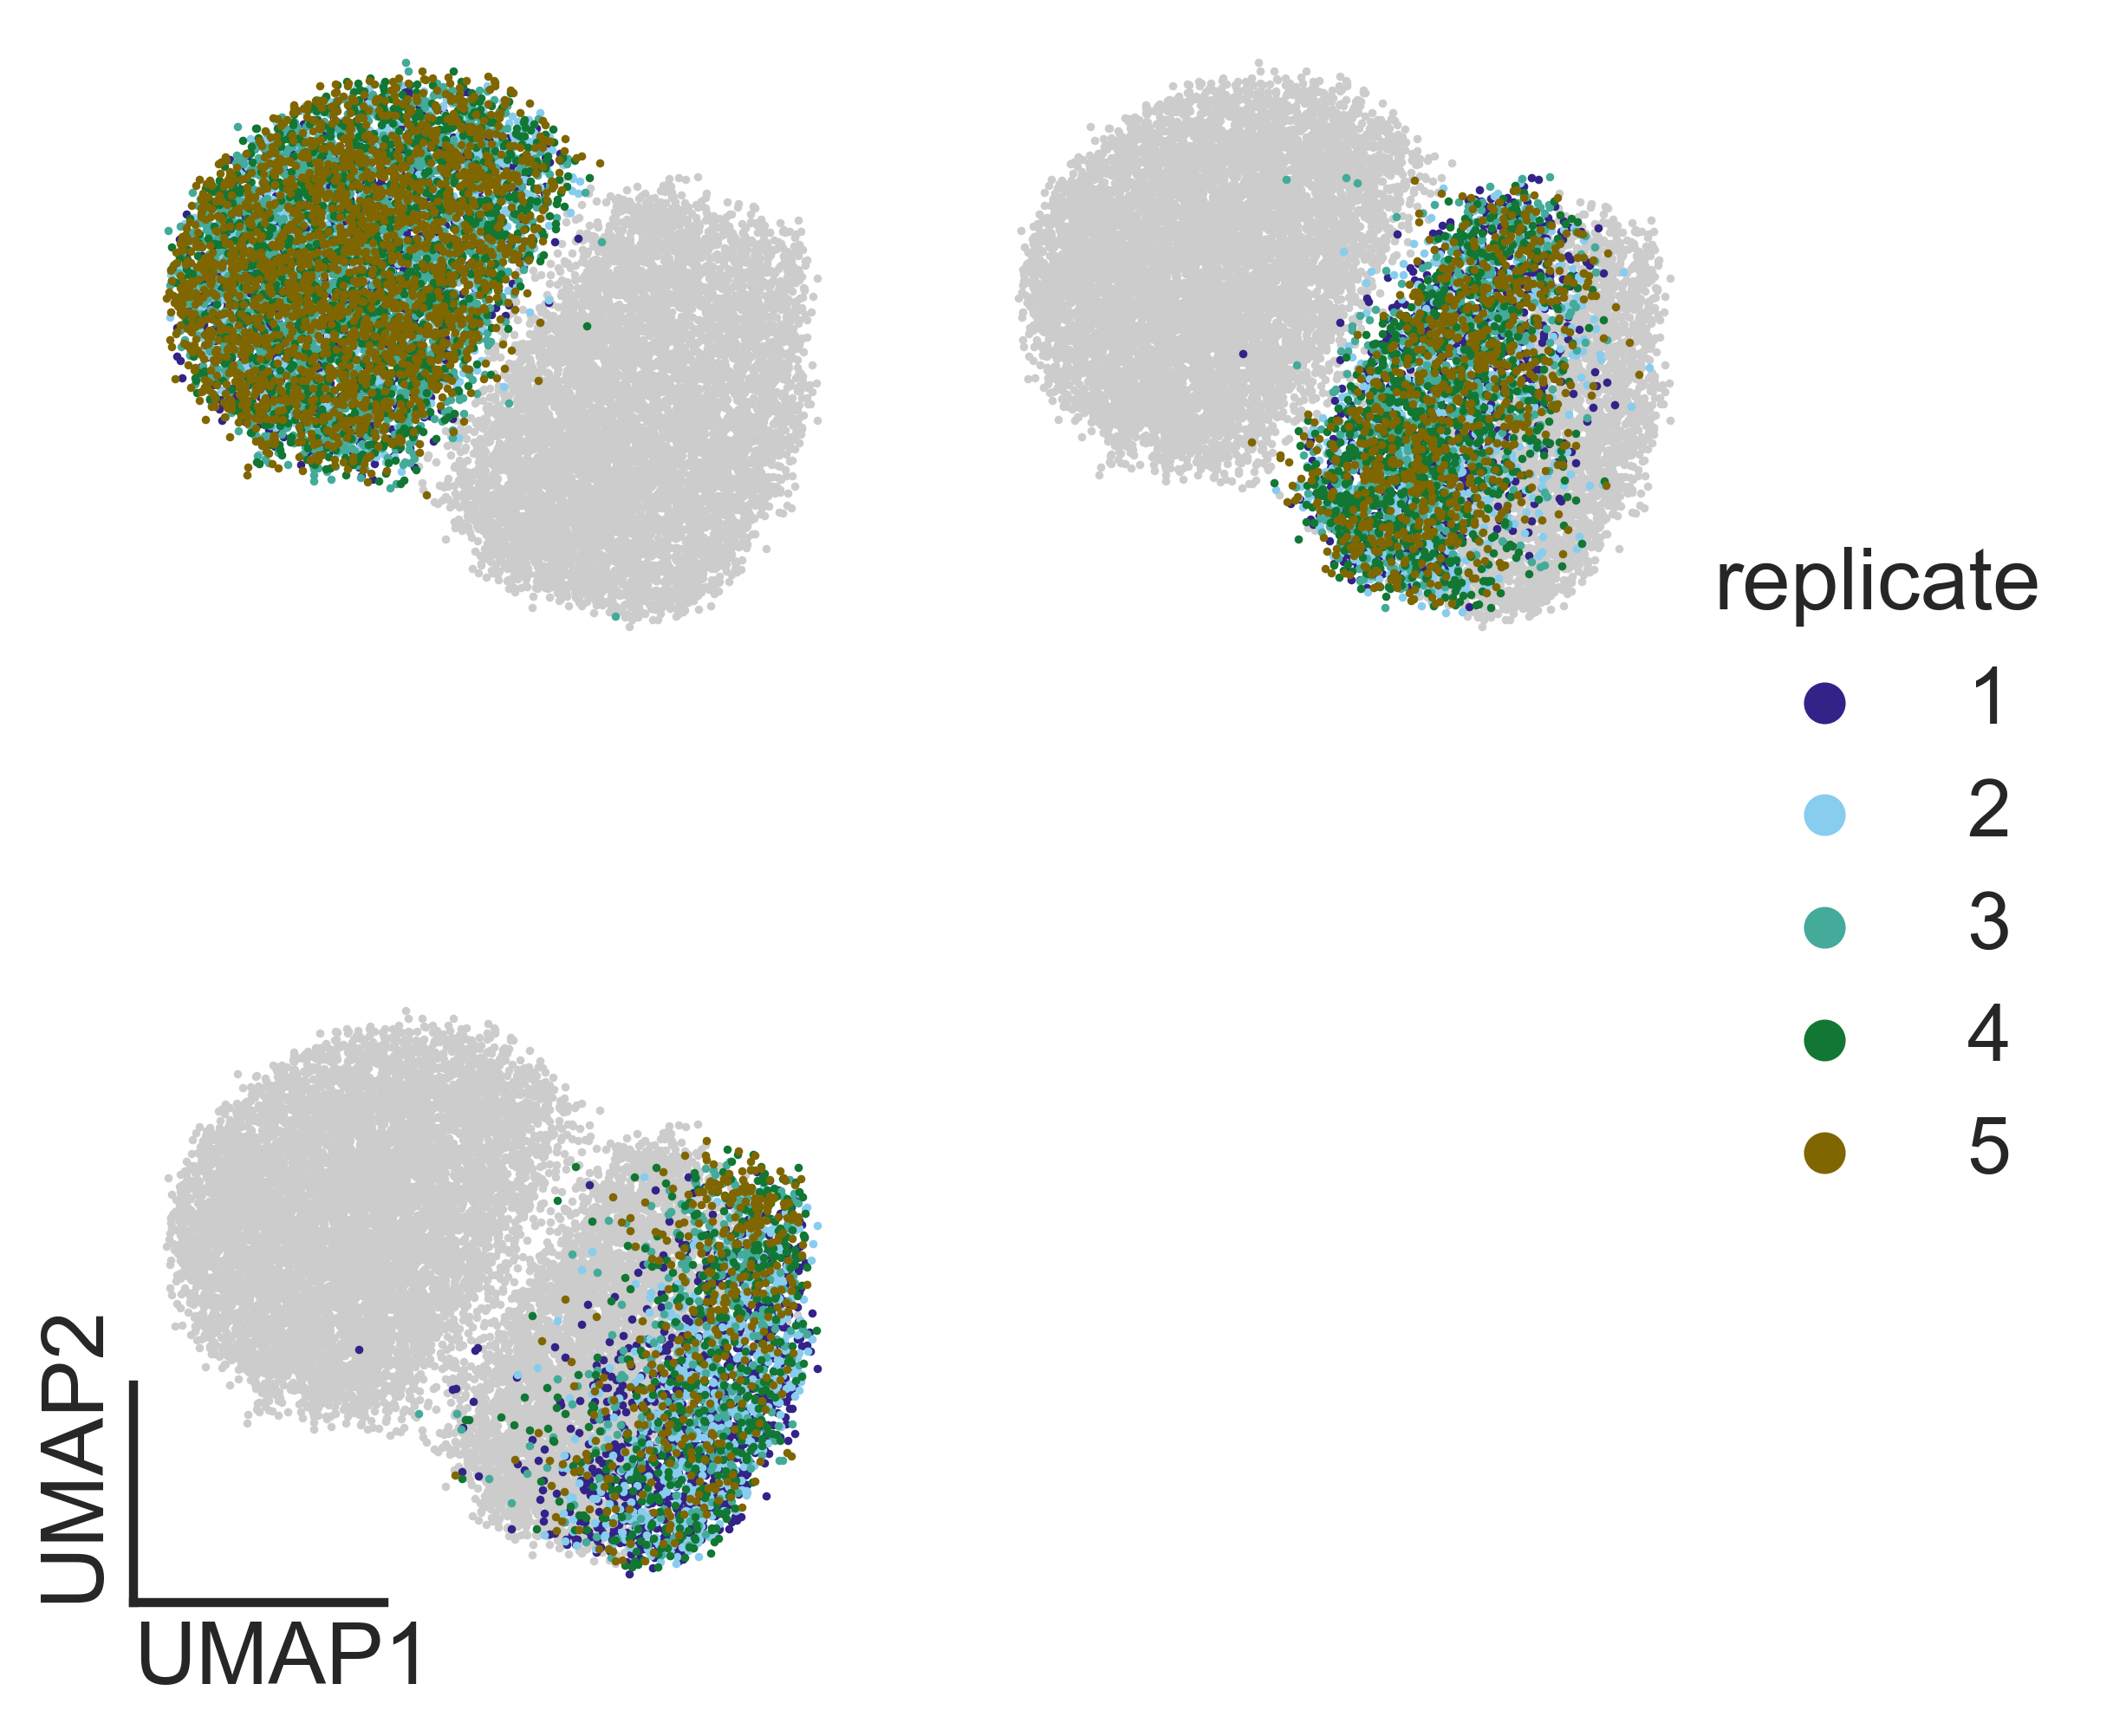

In [7]:
custom_order = ['Control', '2-DG 12h', '2-DG 24h']
adata.obs['condition'] = adata.obs['condition'].astype('category')
adata.obs['condition'] = pd.Categorical(adata.obs['condition'], categories=custom_order, ordered=True)

f = pl.highlight_scatterplot(
    data=adata,
    obsm_key='X_umap',
    hue='replicate',
    col='condition',
    palette=palette,
    col_wrap=2,
    height=3,
    aspect=1,
    decorate_titles=False,
    trim_axes=True,
    scatter_kwargs={'s':3})

f.add_legend(markerscale=5)
f.set_titles(col_template='')

plt.xlabel('UMAP1', loc='left', fontsize=18)
plt.ylabel('UMAP2', loc='bottom', fontsize=18)

plt.savefig(plots_path / 'panel_A.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_A.svg', bbox_inches='tight')

### Panel B - Violin plots
Selected markers based on differential analysis between Control and 2-DG treated cells.

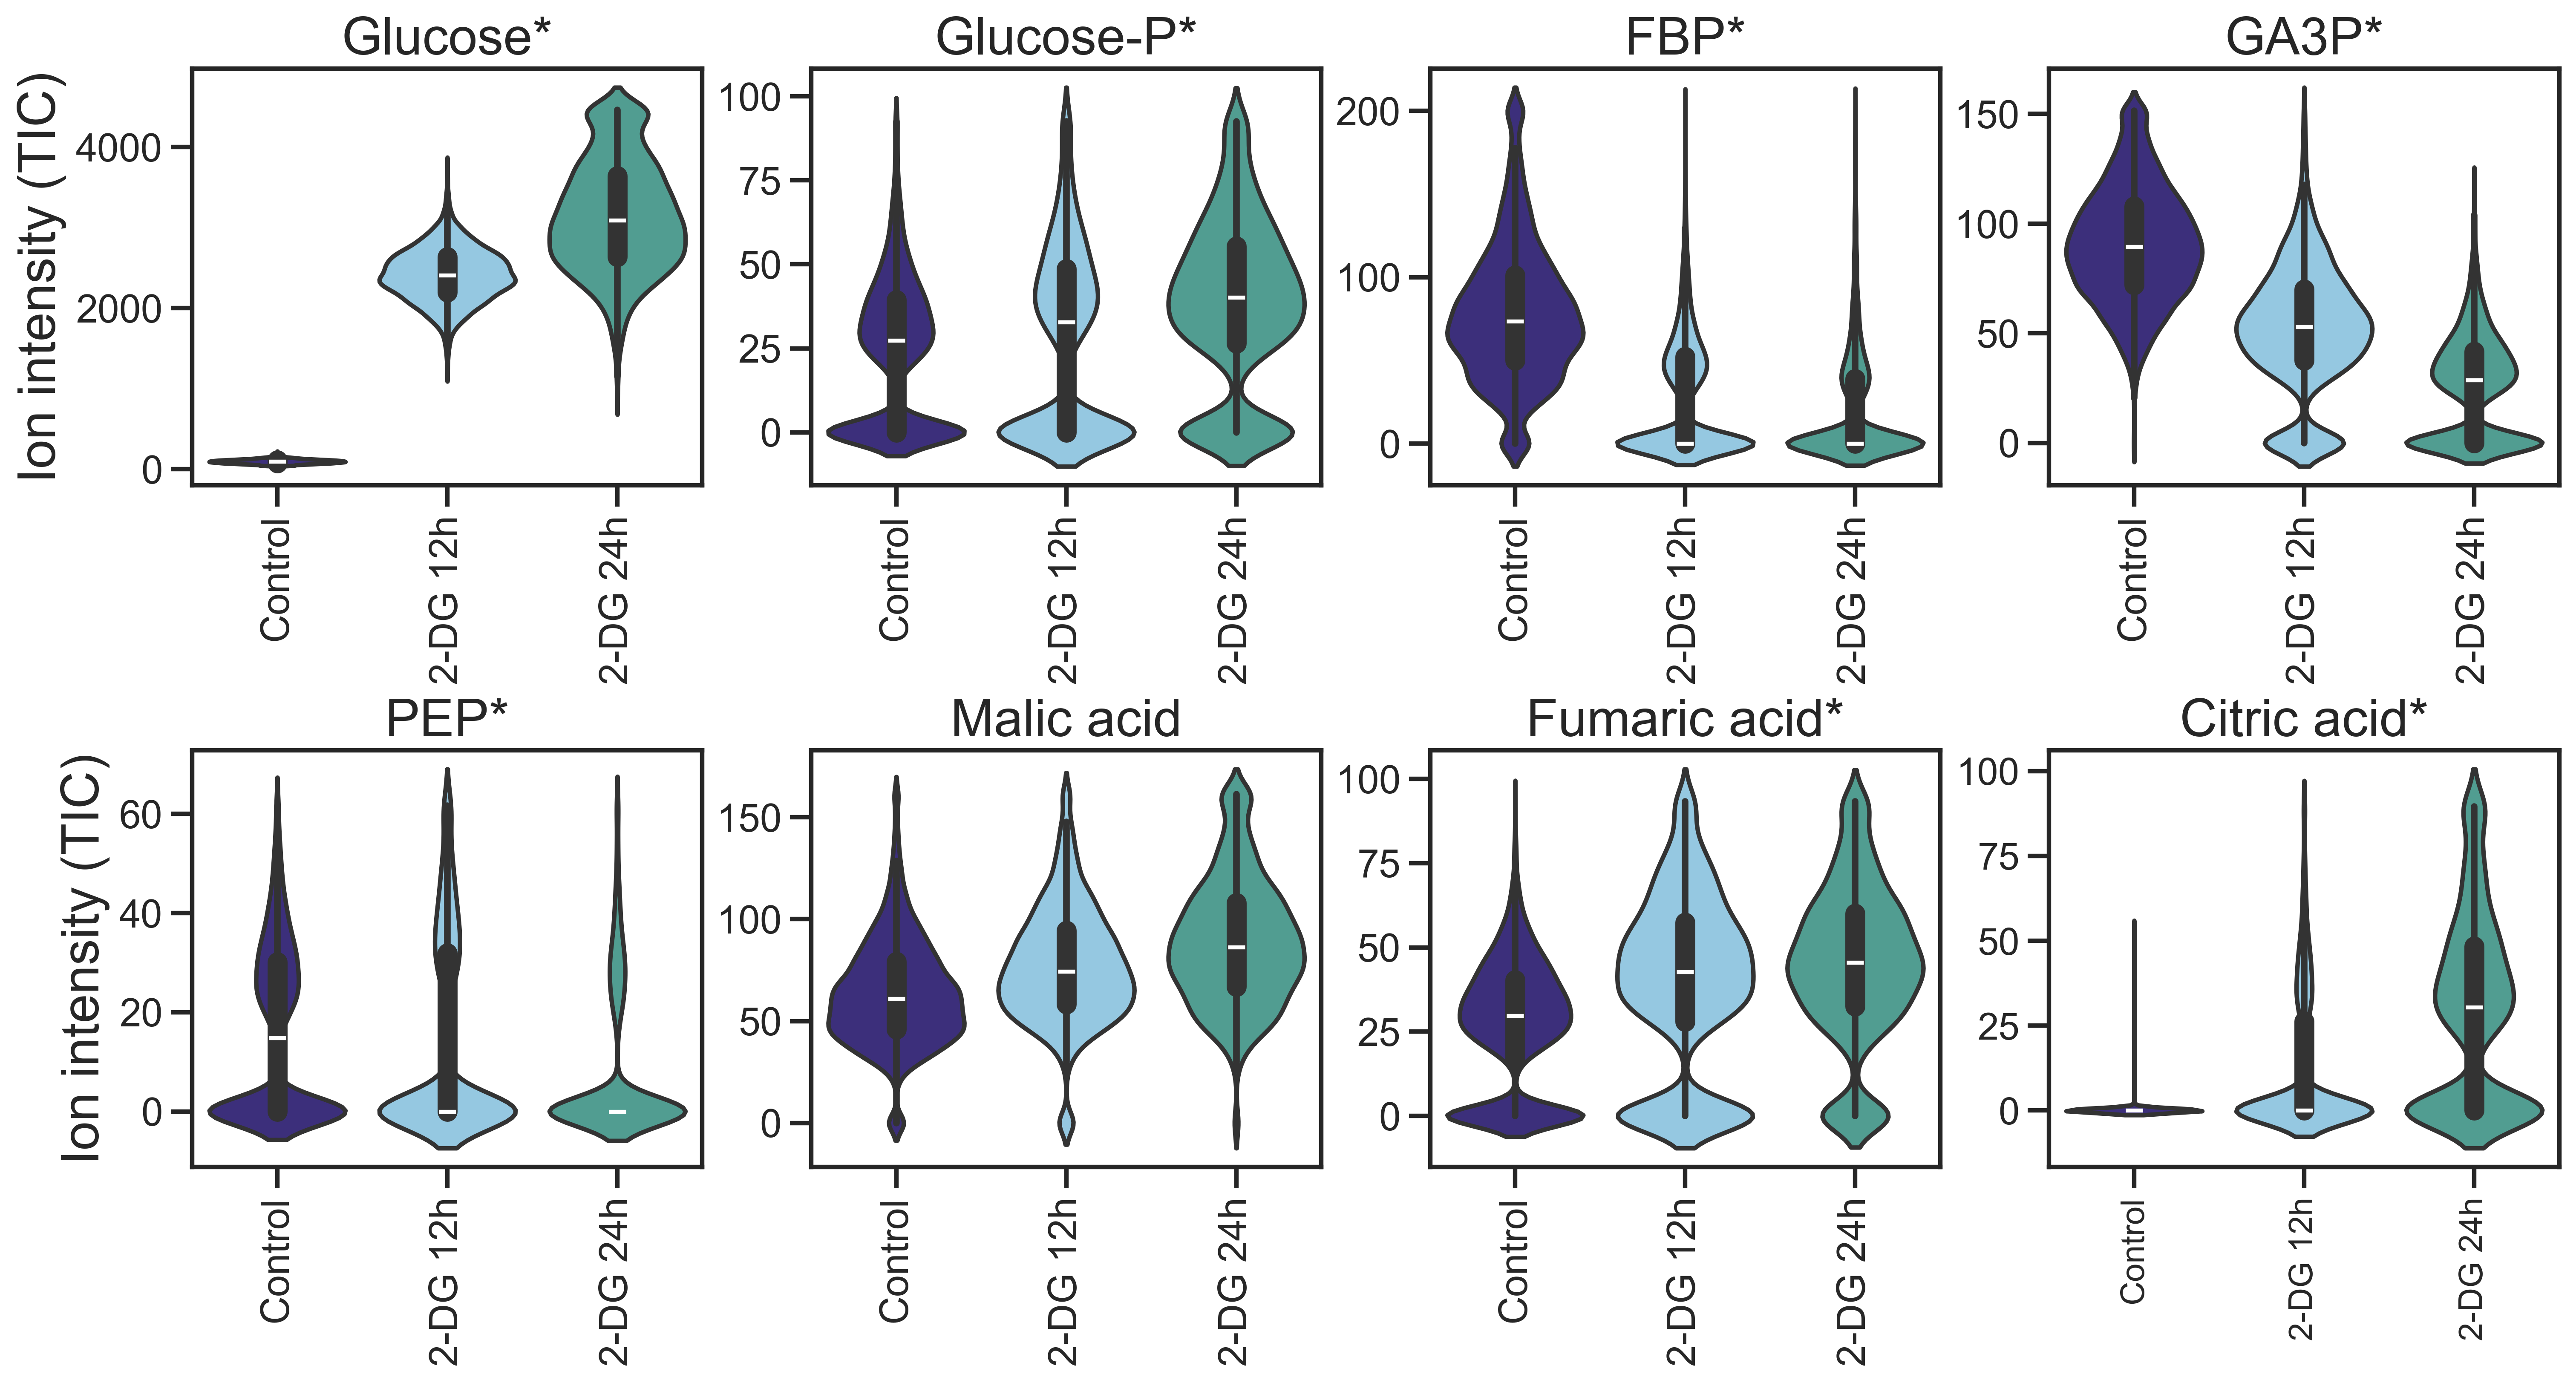

In [8]:
lower, upper = np.quantile(adata.layers['norm_counts'], [0.01, 0.99], axis=0)
adata.layers['clipped'] = np.clip(adata.layers['norm_counts'], lower, upper)

custom_order = ['Control', '2-DG 12h', '2-DG 24h']
adata.obs['condition'] = adata.obs['condition'].astype('category')
adata.obs['condition'] = pd.Categorical(adata.obs['condition'], categories=custom_order, ordered=True)

#top ranked selected markers - 2 HeLa and 2 NIH3T3
glycolysis = ['C6H12O6-H', 'C6H13O9P-H', 'C6H14O12P2-H', 'C3H7O6P-H',
             'C3H5O6P-H', 'C4H6O5-H', 'C4H4O4-H', 'C6H8O7-H']

custom_titles = {'C6H12O6-H': 'Glucose*','C6H13O9P-H': 'Glucose-P*','C6H14O12P2-H': 'FBP*',
                 'C3H7O6P-H': 'GA3P*','C3H5O6P-H': 'PEP*','C4H6O5-H': 'Malic acid',
                 'C4H4O4-H': 'Fumaric acid*','C6H8O7-H': 'Citric acid*'}

# Setup grid: 1 row × 8 columns
fig, axes = plt.subplots(2, 4, figsize=(15, 8), constrained_layout=True)
axes = axes.flatten()

for i, gene in enumerate(glycolysis):
    ax = axes[i]
    data = adata.to_df(layer='clipped')[gene]
    conds = adata.obs['condition']

    sns.violinplot(x=conds, y=data, palette=palette[0:3], ax=ax, order=custom_order, hue=conds)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(custom_titles.get(gene, gene), fontsize=22)
    ax.set_xlabel("")
    if i % 4 != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Ion intensity (TIC)", fontsize=22)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=14)

    plt.savefig(plots_path / 'panel_B.png', bbox_inches='tight')
    plt.savefig(plots_path / 'panel_B.svg', bbox_inches='tight')

### Panel C - Dotplot

In [9]:
sc.pp.pca(adata)
sc.tl.dendrogram(adata, groupby='condition', cor_method='pearson')
lower, upper=np.quantile(adata.layers['norm_counts'], [0.0, 0.99], axis=0)
adata.layers['clipped']=np.clip(adata.layers['norm_counts'], lower, upper)

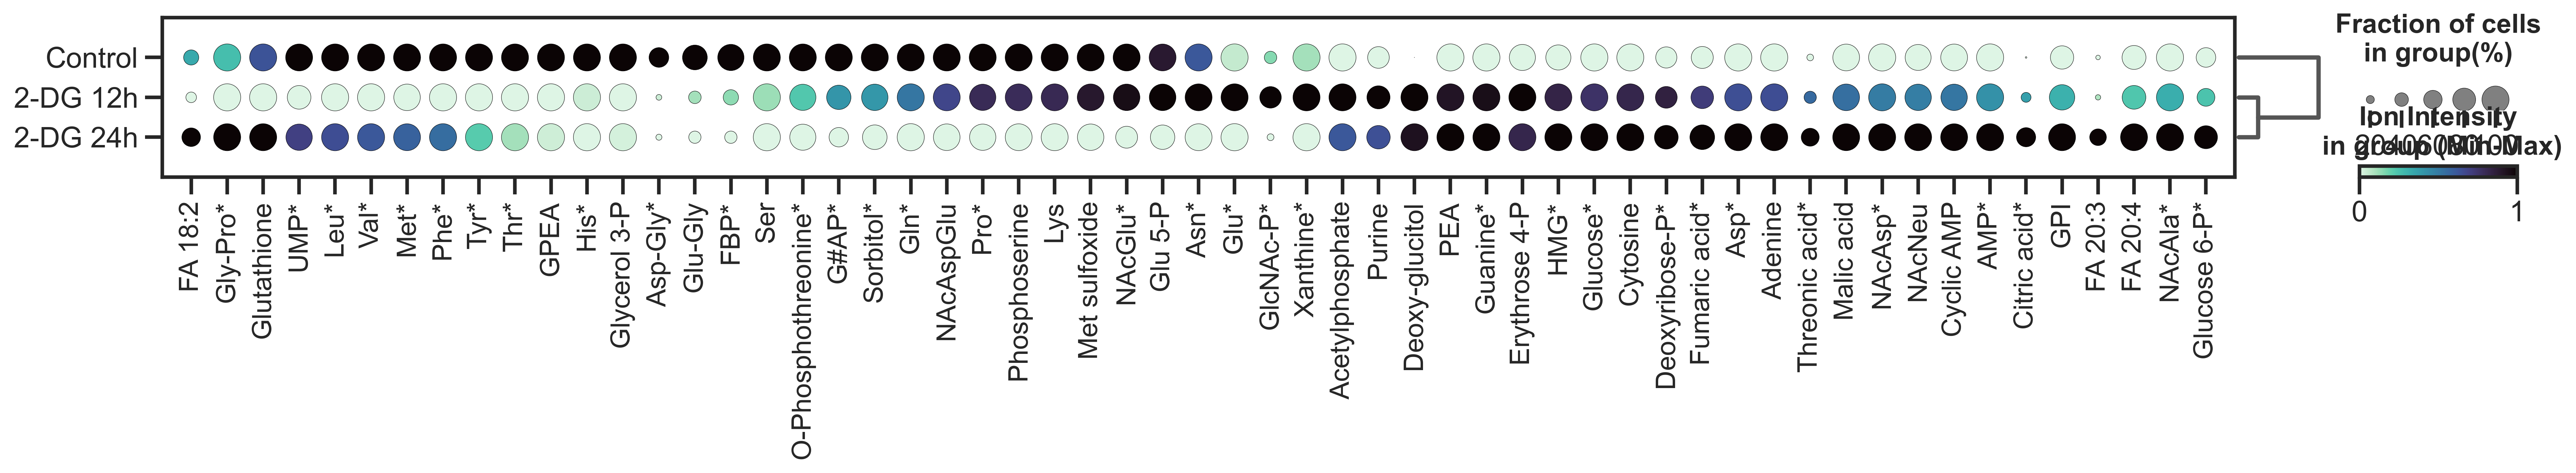

In [10]:
ax = sc.pl.dotplot(adata,
                   var_names=DA_markers['ion'],
                   layer='clipped',
                   groupby='condition',
                   use_raw=False,
                   dendrogram=True,
                   figsize=[22, 1.5],
                   swap_axes=False,
                   show=False,
                   cmap='mako_r',
                   standard_scale='var',
                   mean_only_expressed=False,
                   colorbar_title='Mean Intensity\nin group\n(Scaled')

ax['mainplot_ax'].set_xticklabels(labels=DA_markers['metabolites'],fontsize=14)
ax['color_legend_ax'].set_title(label='Ion Intensity\n in group (Min-Max)', fontsize=14,  weight='bold')
ax['size_legend_ax'].set_title(label='Fraction of cells\nin group(%)', fontsize=14,  weight='bold')

plt.savefig(plots_path / 'panel_C.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_C.svg', bbox_inches='tight')

## Panel D
See the code in the notebook of Figure 7 panel D

## Panel E and Panel F

### Set paths

In [11]:
#input
data_dir = Path(r'../data')
anndata_path = data_dir / 'SC3_normalized.h5ad'

#output
plots_path =  Path(r'../') / 'figures' / 'supplementary_figure_5'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [12]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)
adata.raw = adata

In [13]:
sc.pp.pca(adata)
sc.external.pp.bbknn(adata, batch_key='well')
sc.tl.umap(adata, random_state=12345) 
adata.obs[['UMAP1', 'UMAP2']] = adata.obsm['X_umap']
# Using leiden for unsupervised clustering

In [14]:
#Clustering control
adata_CT = adata[adata.obs['condition'] == 'Control', :]
sc.tl.leiden(adata_CT, resolution=0.5, flavor='leidenalg')
adata_CT.obs['leiden'] = adata_CT.obs['leiden'].cat.rename_categories({'0': 'Control_0', '1': 'Control_1'})

#Clustering 2DG-12h
adata_12h = adata[adata.obs['condition'] == '2-DG 12h', :]
sc.tl.leiden(adata_12h, resolution=0.5, flavor='leidenalg')
adata_12h.obs['leiden'] = adata_12h.obs['leiden'].cat.rename_categories({'0': '2-DG 12h_0', '1': '2-DG 12h_1'})

#Clustering 2DG-24h
adata_24h = adata[adata.obs['condition'] == '2-DG 24h', :]
sc.tl.leiden(adata_24h, resolution=0.4, flavor='leidenalg')
adata_24h.obs['leiden'] = adata_24h.obs['leiden'].cat.rename_categories({'0': '2-DG 24h_0', '1': '2-DG 24h_1'})

adata_combined = adata_CT.concatenate(adata_12h, adata_24h, join='outer', index_unique='-')

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_34620/3959903884.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_CT, resolution=0.5, flavor='leidenalg')
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/scanpy/tools/_leiden.py:197: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/scanpy/tools/_leiden.py:197: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/scan

### Panel E

/Users/jeanydelafiori/Apps/outer-spacem/outer_spacem/tl/_tl.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comps = adata.obs.groupby(key_split)[key_count].value_counts(normalize=True)


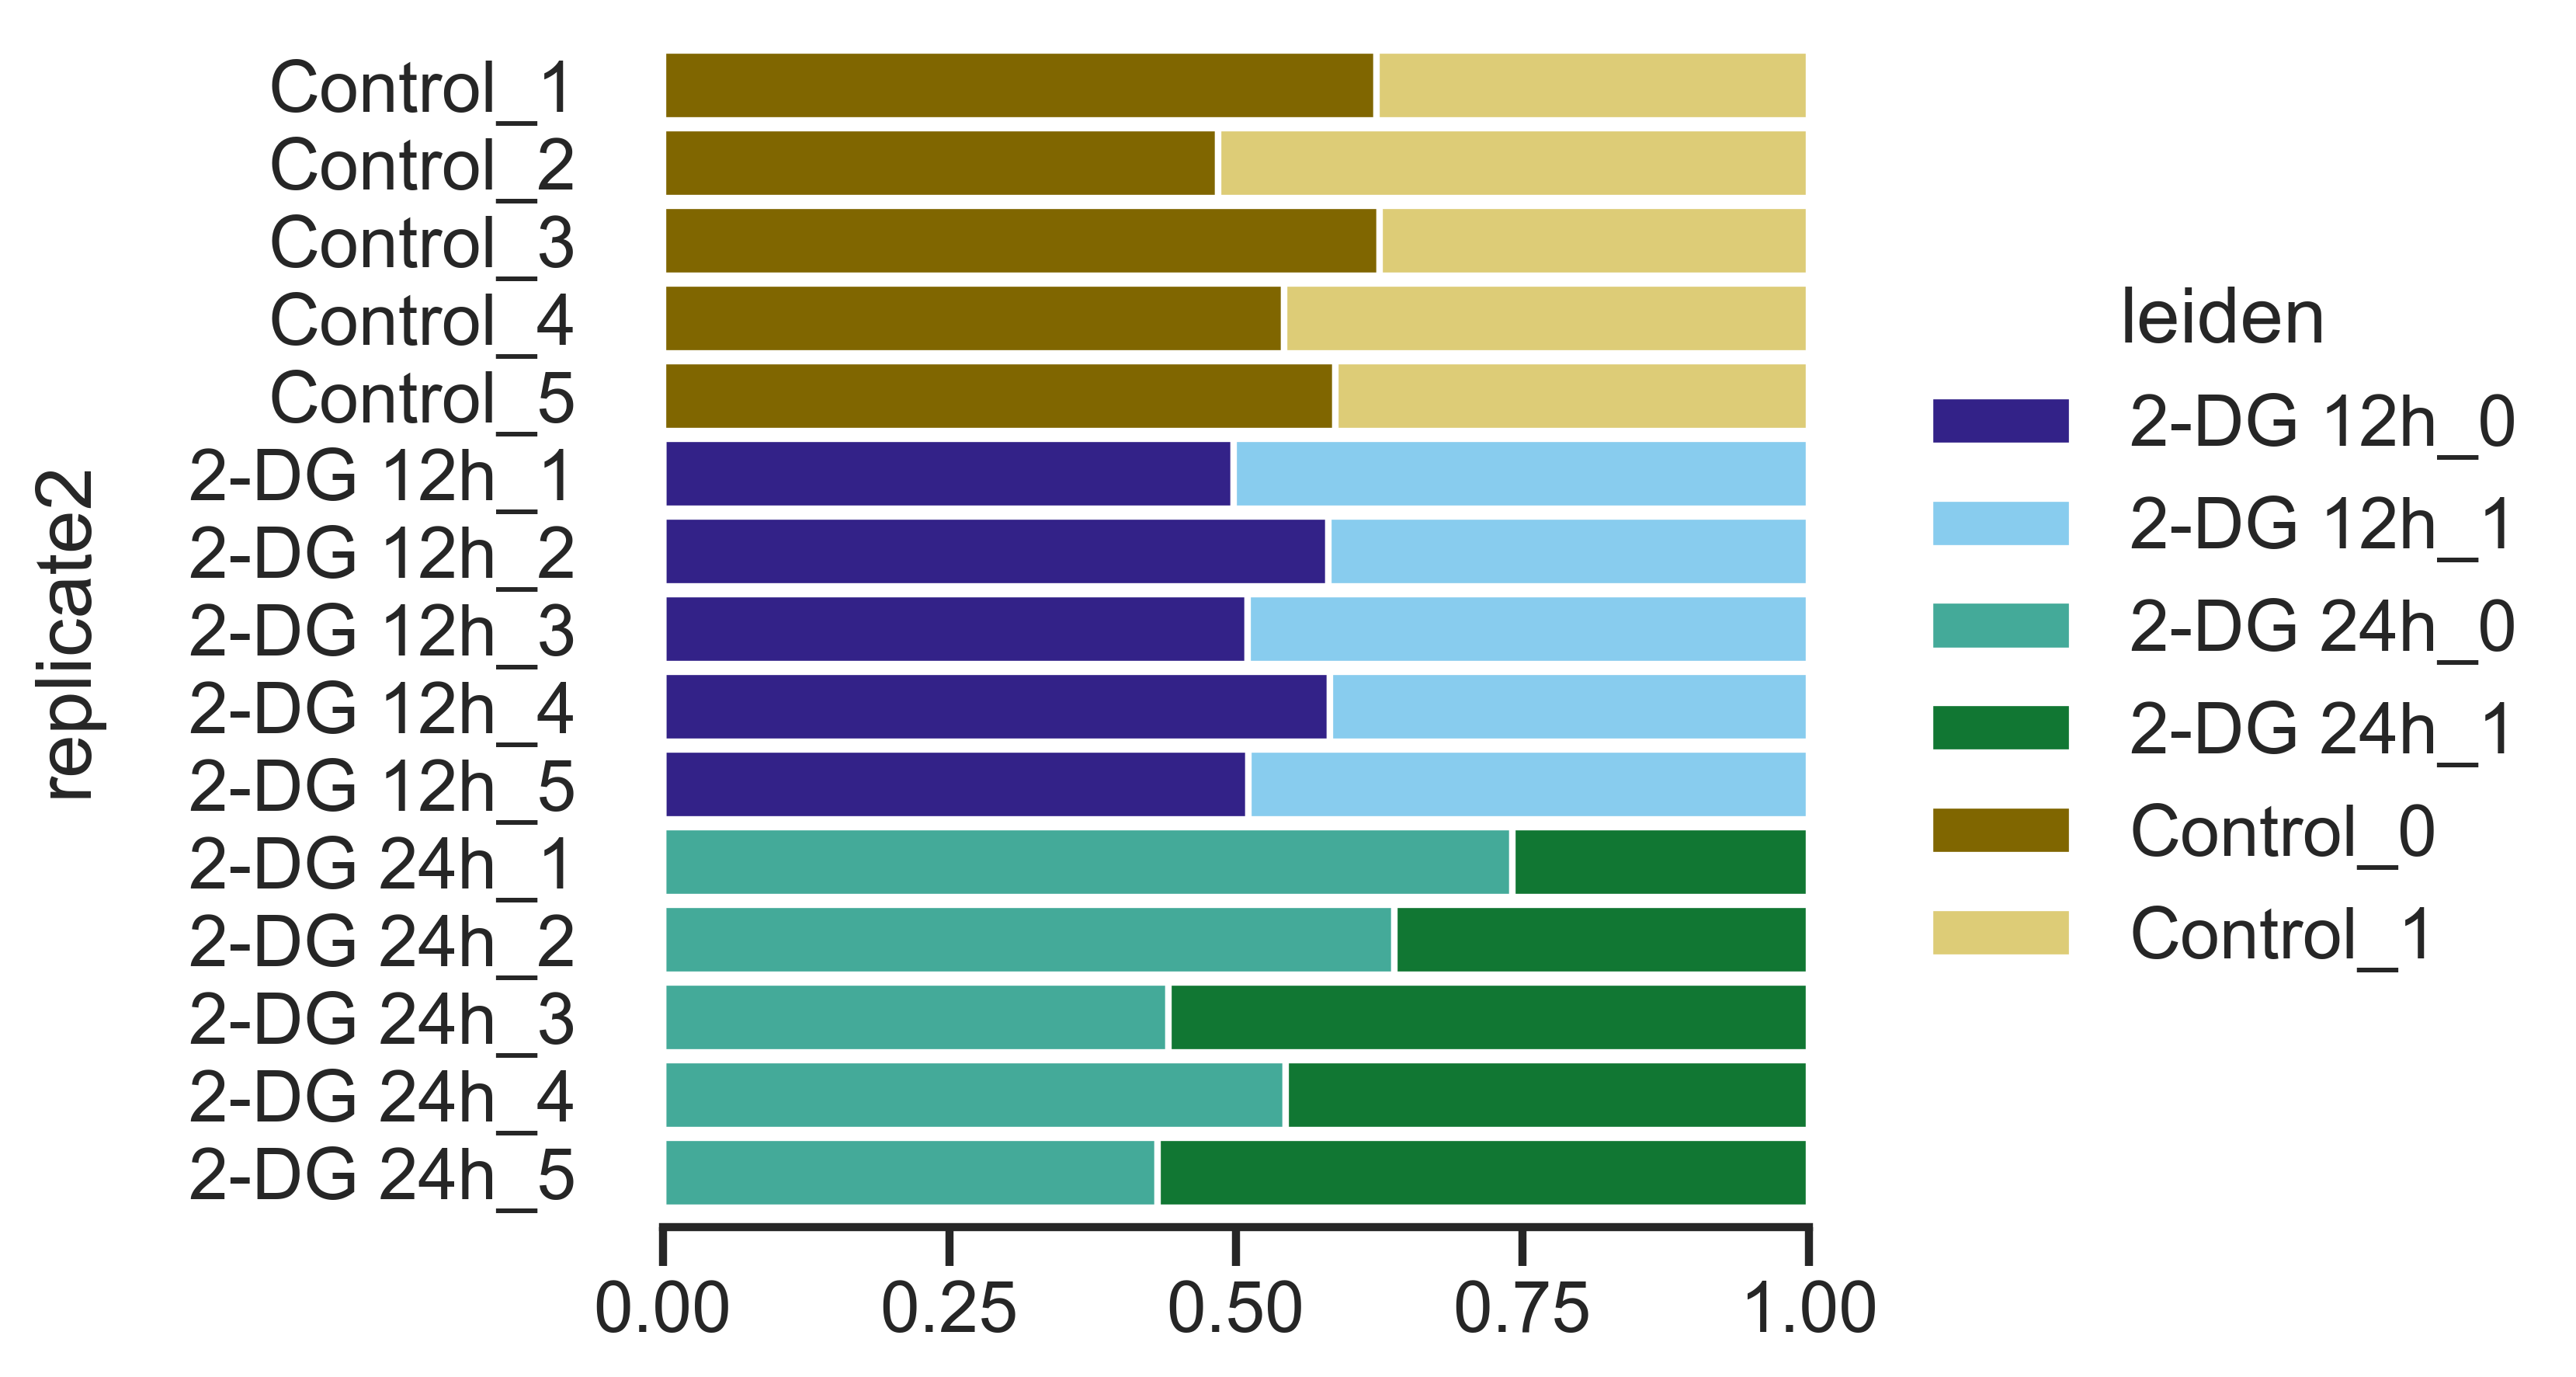

In [15]:
custom_order = ['2-DG 24h_5','2-DG 24h_4','2-DG 24h_3','2-DG 24h_2', '2-DG 24h_1',
               '2-DG 12h_5','2-DG 12h_4','2-DG 12h_3','2-DG 12h_2', '2-DG 12h_1',
               'Control_5','Control_4','Control_3','Control_2', 'Control_1',]

adata_combined.obs['replicate2'] = adata_combined.obs['replicate2'].astype('category')
adata_combined.obs['replicate2'] = pd.Categorical(adata_combined.obs['replicate2'], categories=custom_order, ordered=True)

g = osm.pl.cross_label_counts_stacked(
    adata_combined, 
    key_split="replicate2", 
    key_count="leiden", 
    palette=palette,
    normalize="relative",
    decorate_yticks=False
)
g.grid(False)
plt.savefig(plots_path / 'panel_E_barplot.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_E_barplot.svg', bbox_inches='tight')

### Panel F


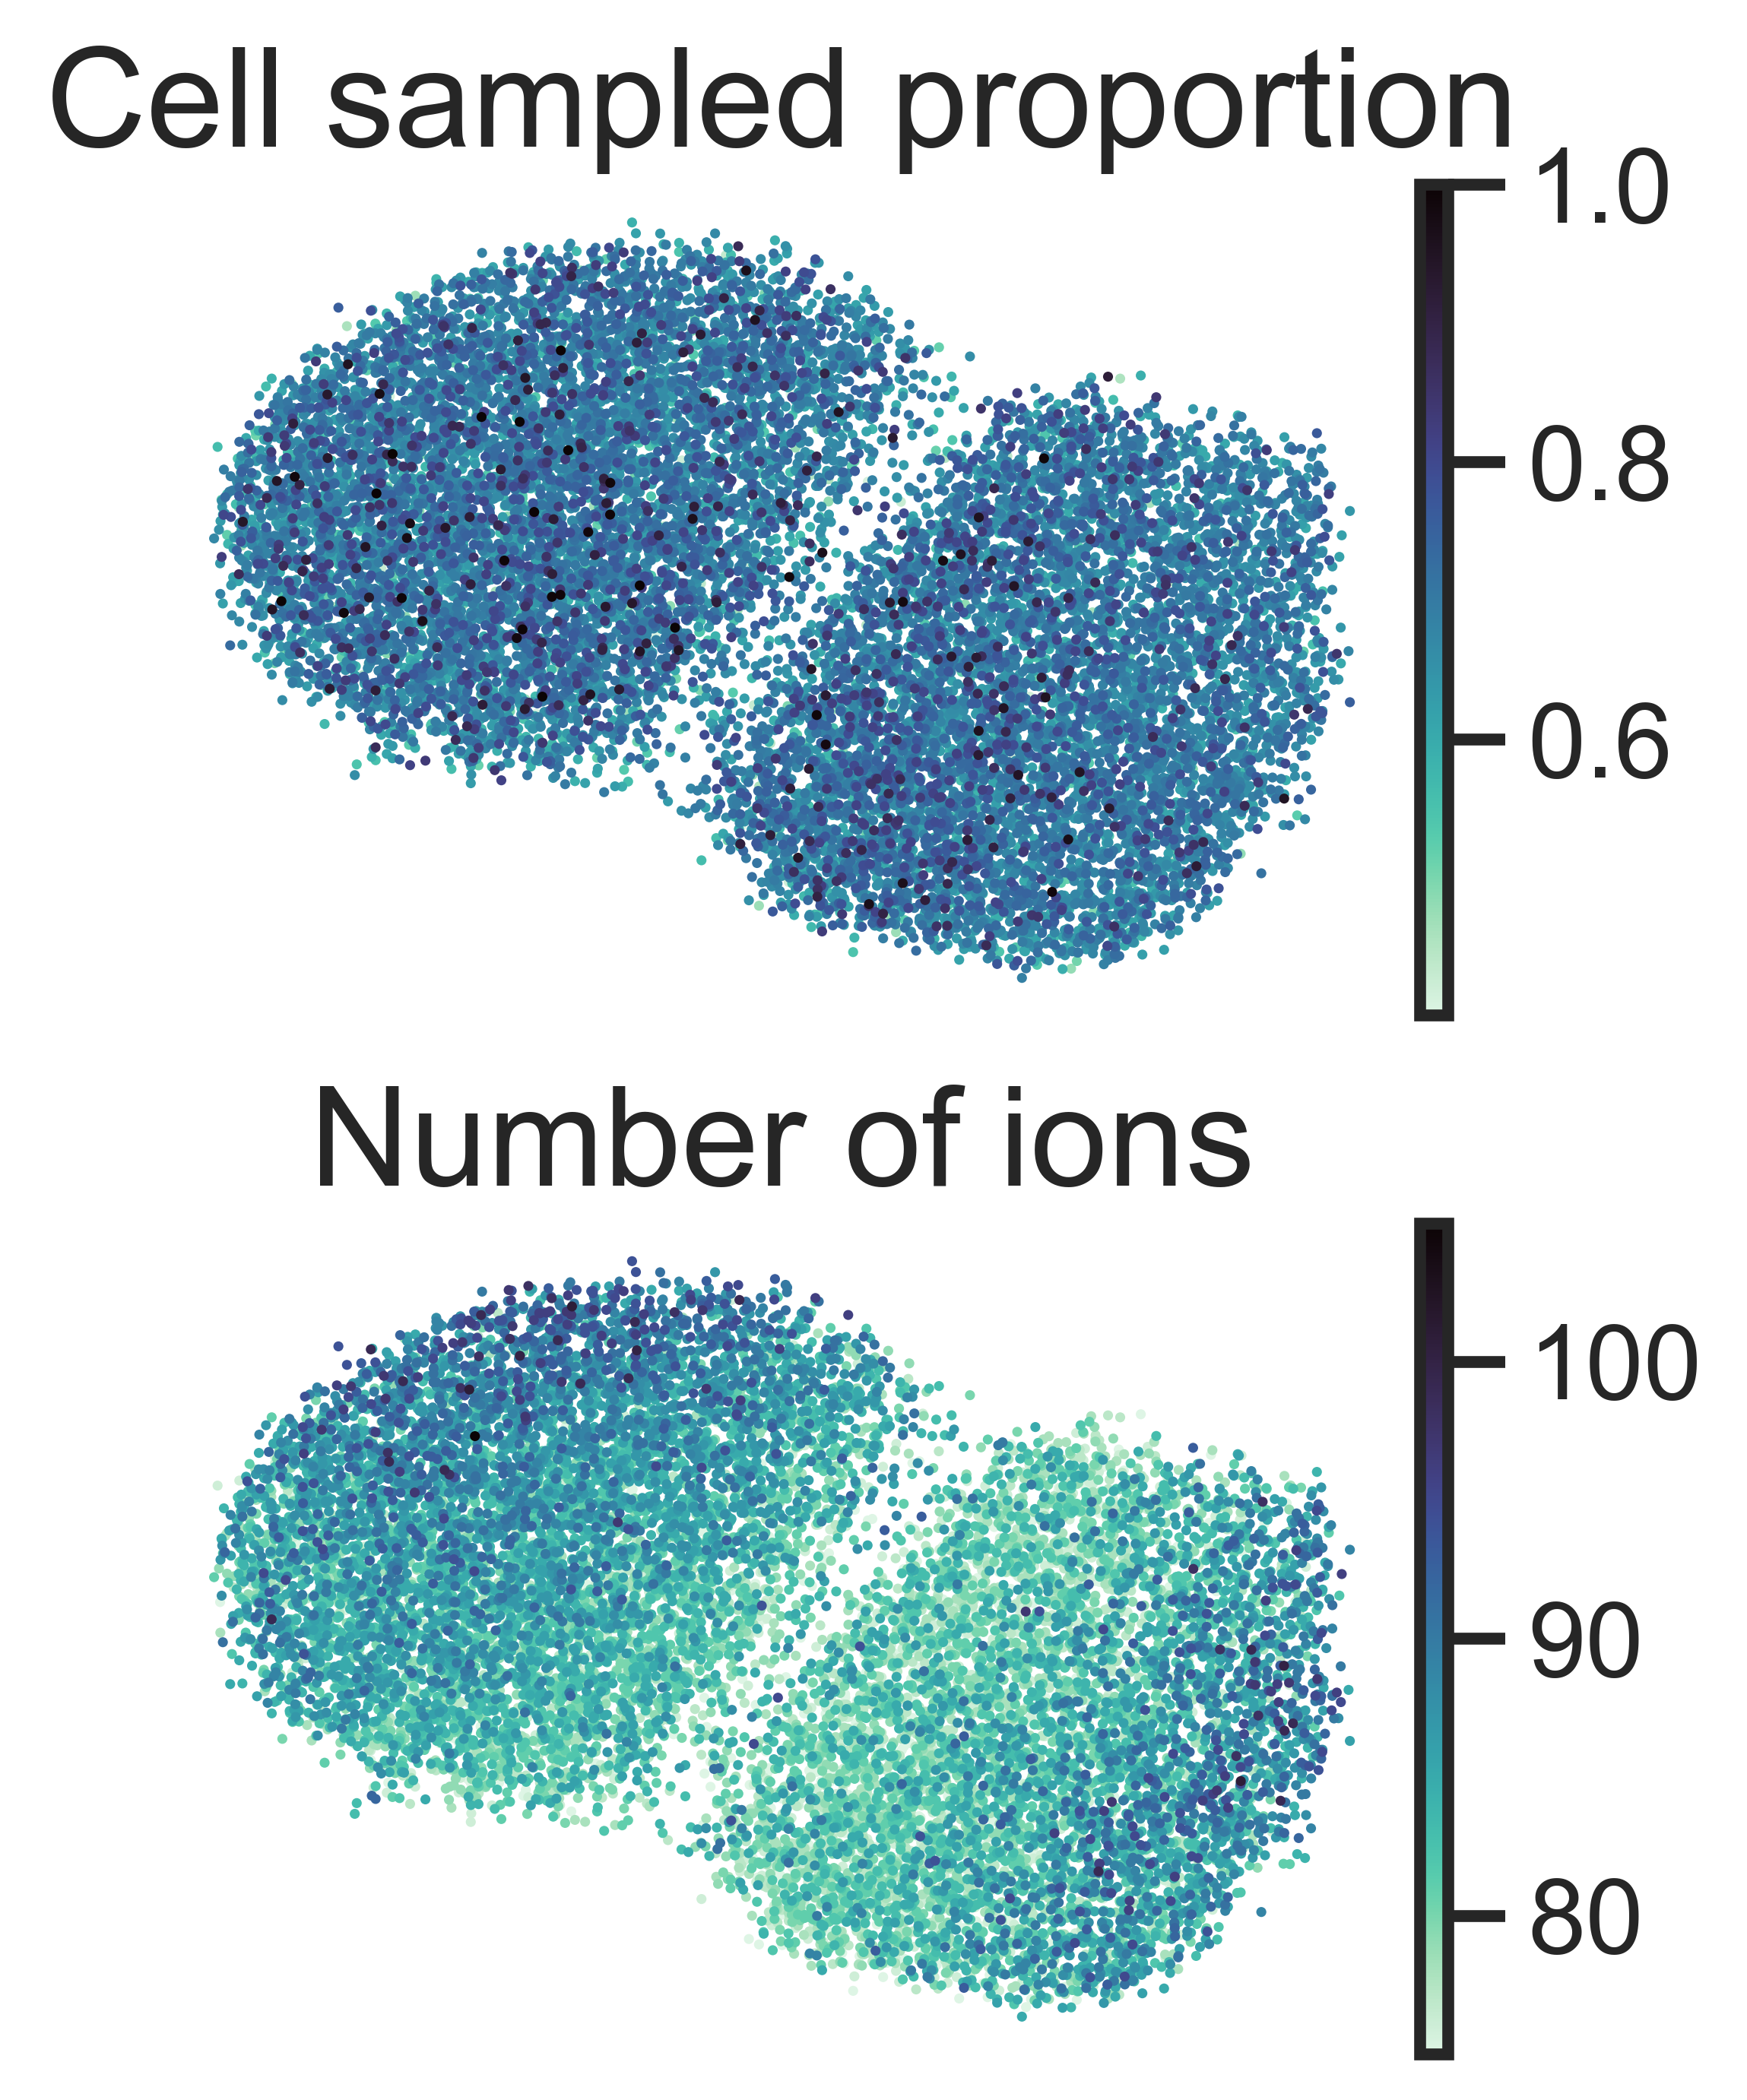

In [16]:
lower, upper = np.quantile(adata.layers['norm_counts'], [0.01, 0.99], axis=0)
adata.layers['clipped'] = np.clip(adata.layers['norm_counts'], lower, upper)

#top ranked markers - clusters 1 and 2
clustering = ['cell_sampled_proportion', 'n_genes']

with plt.rc_context({'figure.figsize':(3, 2.5),  'figure.dpi':(300), 'axes.titlesize':22, 'legend.fontsize':22}):
    f = sc.pl.umap(adata,
                   color= clustering,
                   cmap='mako_r',
                   s=10,
                   layer='clipped',
                   frameon=False,
                   ncols=1,
                   title=['Cell sampled proportion', 'Number of ions'],
                   show=True,
                   return_fig=True)
    plt.savefig(plots_path / 'panel_F_UMAP.png', bbox_inches='tight')
    plt.savefig(plots_path / 'panel_F_UMAP.svg', bbox_inches='tight')

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_34620/269034481.py:16: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.violinplot(
/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_34620/269034481.py:16: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.violinplot(


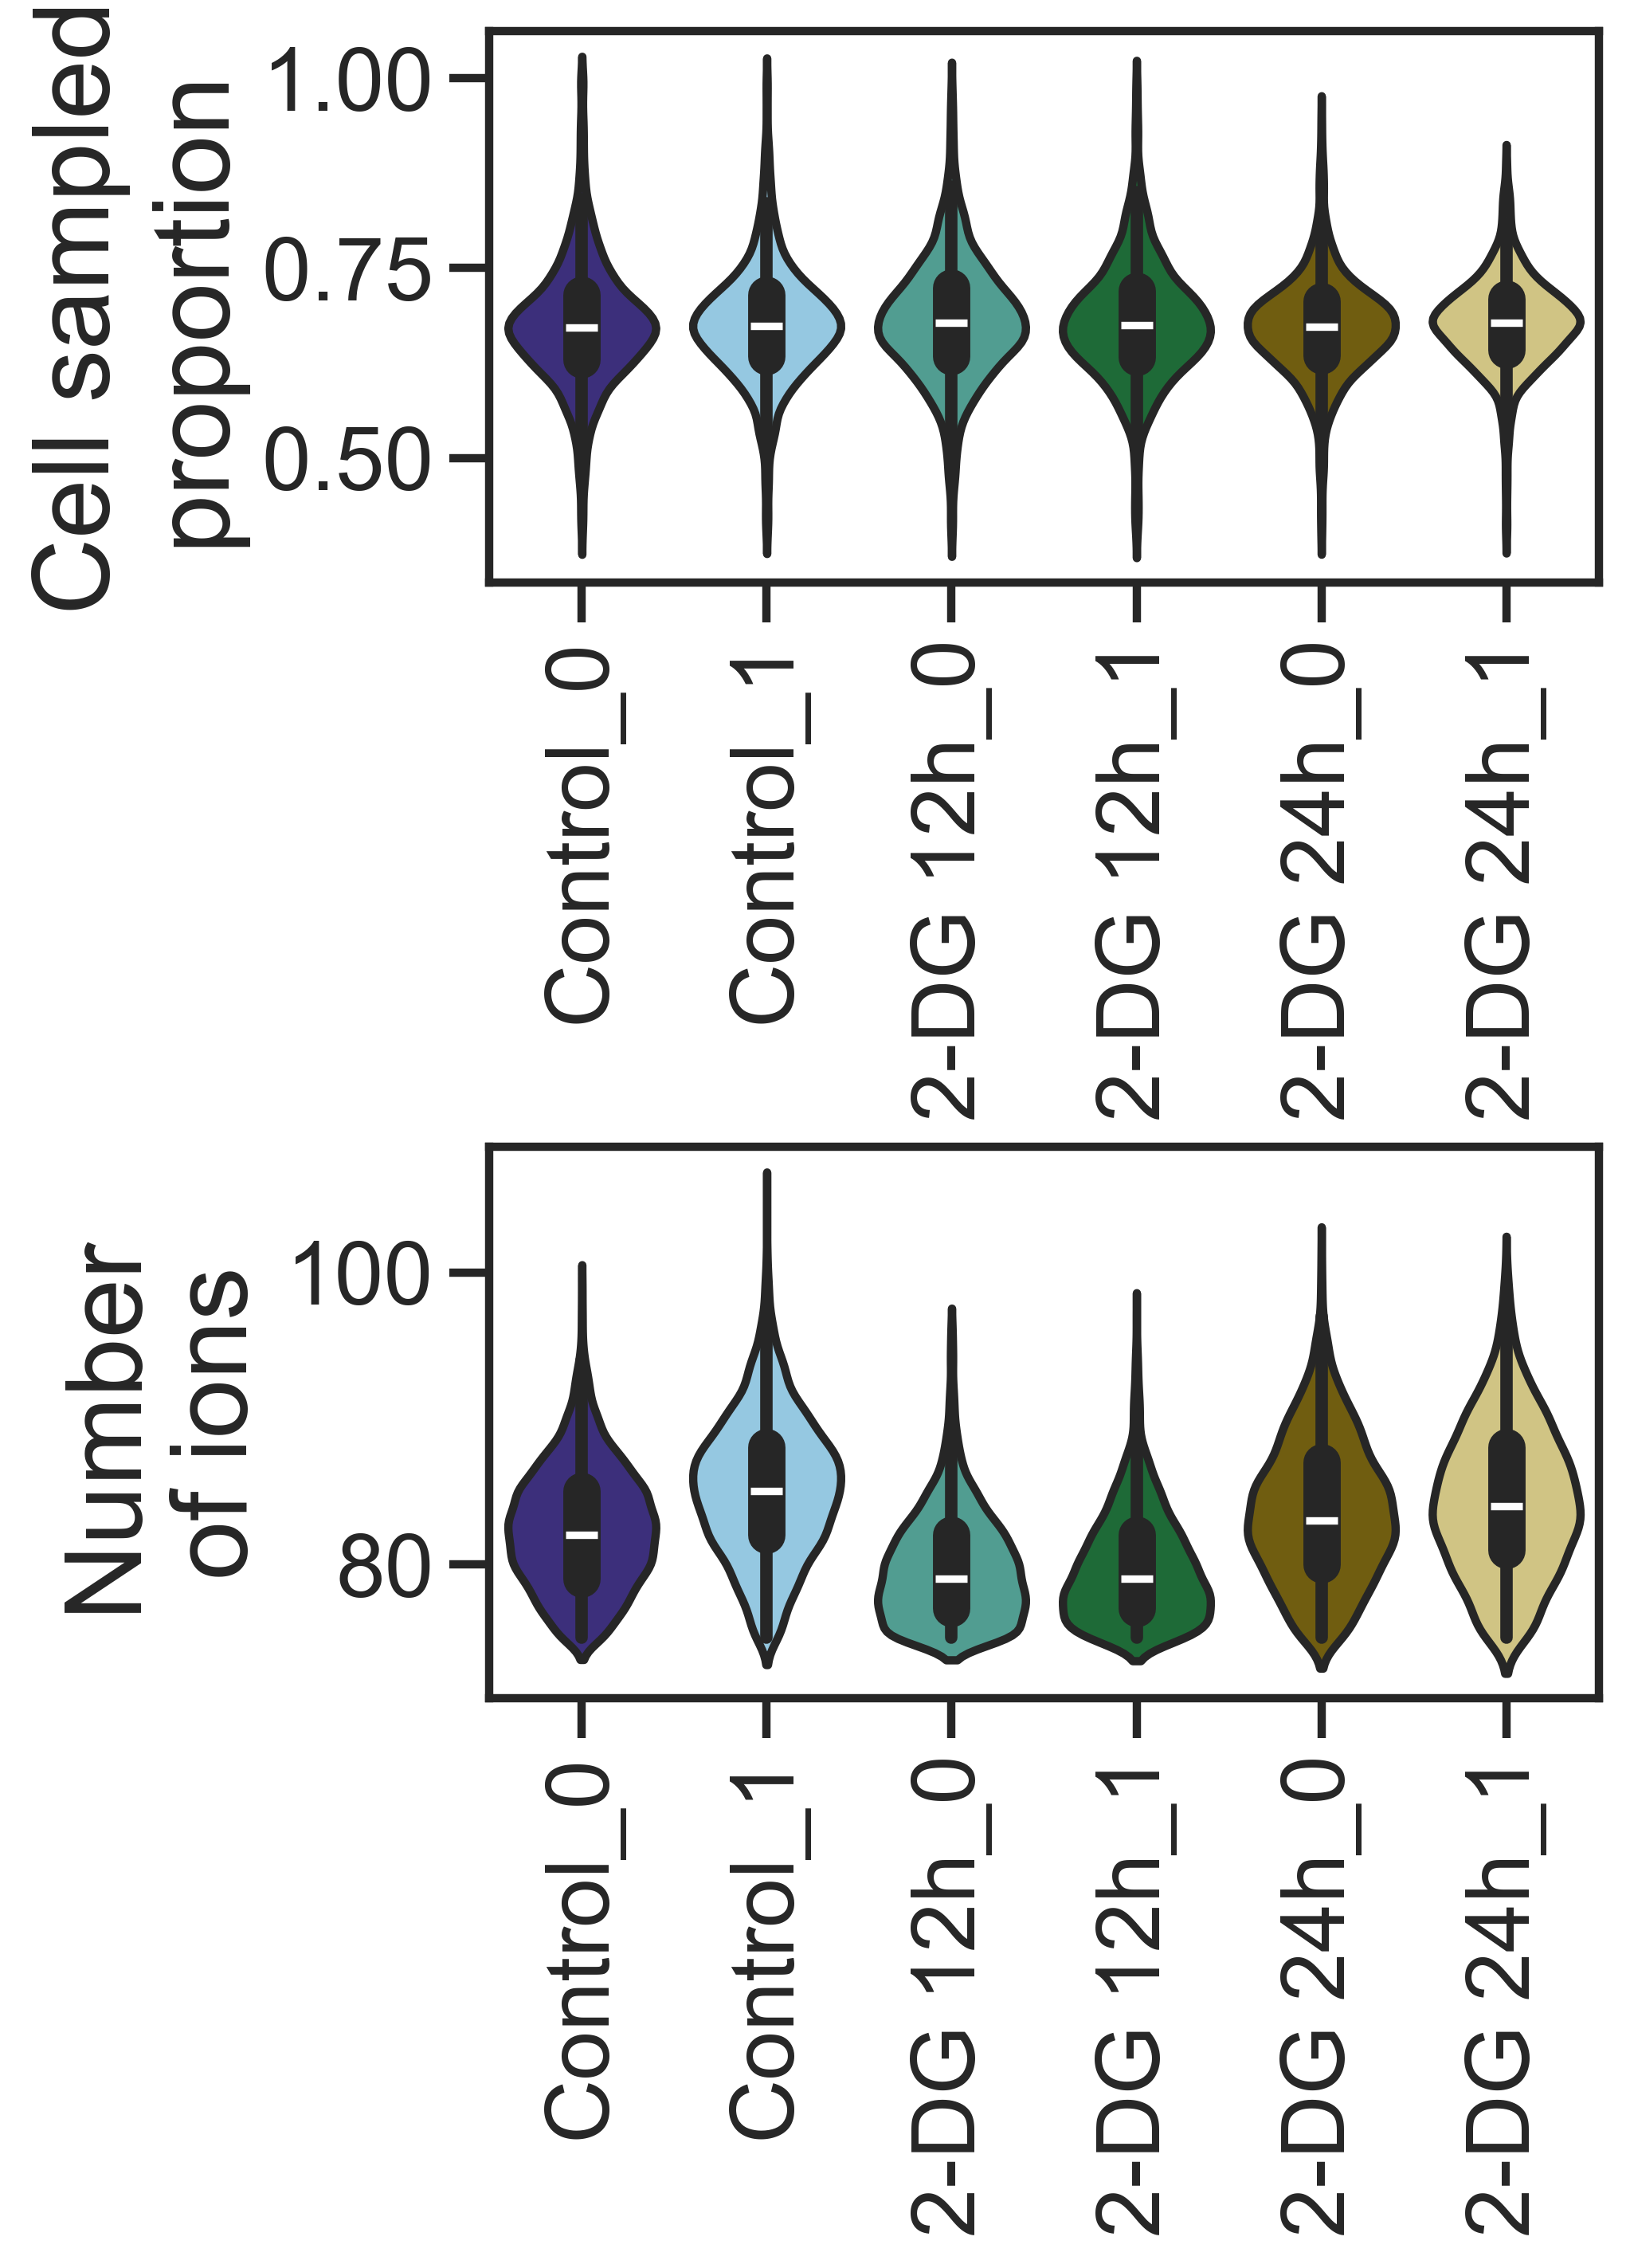

In [17]:
custom_order = ['Control_0', 'Control_1', '2-DG 12h_0', '2-DG 12h_1', '2-DG 24h_0', '2-DG 24h_1']
adata_combined.obs['leiden'] = adata_combined.obs['leiden'].astype('category')
adata_combined.obs['leiden'] = pd.Categorical(adata_combined.obs['leiden'], categories=custom_order, ordered=True)

variables = ['cell_sampled_proportion', 'n_genes']

custom_titles = {'cell_sampled_proportion': 'Cell sampled\nproportion',
                 'n_genes': 'Number\nof ions'}

# Setup grid: 1 row × 8 columns
fig, axes = plt.subplots(2, 1, figsize=(5, 7), constrained_layout=True)
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]
    sns.violinplot(
        data=adata_combined.obs,
        x='leiden',
        hue='leiden',
        y=var,
        palette=palette,
        ax=ax,
        order=custom_order
    )
    #ax.set_title(custom_titles.get(var, var), fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel(custom_titles.get(var, var), fontsize=24)
    ax.tick_params(axis='x', labelrotation=90, labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

# Save plot
plt.savefig(plots_path / 'panel_F_violin.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_F_violin.svg', bbox_inches='tight')
plt.show()